# Kandinsky Patterns

## Lab 2

Tymoteusz Barciński, Agata Kaczmarek, Mateusz Stączek

### How sure the models are when making predictions?


#### Loading and processing (scaling) data

Link to original code for generating: https://github.com/human-centered-ai-lab/app-kandinsky-pattern-generator

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from  torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torchvision import models
import os
import torch.nn.functional as F
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cpu


In [2]:
folder = '/work/newly_generated_data/shapeonshapes_1k'

classes = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
classes = [classes[2], classes[1], classes[0]] 

print(f"Classes found: {classes}")

Classes found: ['counterfactual', 'false', 'true']


#### Creating data loaders.

In [3]:
num_classes = 3
batch_size=16

train_size=2500
test_size=250
val_size=250


transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize([256, 256])])

train_set = ImageFolder('/work/newly_generated_data/shapeonshapes_1k', transform = transform)

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(train_set,
                                               [train_size, test_size, val_size])
trainloader = torch.utils.data.DataLoader(
     train_dataset, batch_size=batch_size, shuffle=False)

testloader = torch.utils.data.DataLoader(
     test_dataset, batch_size=batch_size, shuffle=False)

valloader = torch.utils.data.DataLoader(
     val_dataset, batch_size=batch_size, shuffle=False)

#### Some helper functions

In [4]:
def check_predictions(model, loader, print_acc = True, return_results = False):
    total=0
    correct=0
    probabilities = []
    is_correct = []

    for data in loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

        probabilities += nn.functional.softmax(outputs, dim=1).max(dim=1).values.detach().numpy().tolist()
        is_correct += (pred == labels).numpy().tolist()
    if print_acc:
        print(f"Accuracy is: {100 * correct / total}")
    if return_results:
        return np.array(is_correct), np.array(probabilities)

In [5]:
def plot_hist(models, loader, model_names):
    facecolors = ['g','b','r']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    ax2.set_xlim((0,1))
    ax1.set_xlim((0,1))

    for model, model_name, facecolor in zip(models, model_names, facecolors):
        is_correct_np, probabilities_np = check_predictions(model, loader, print_acc=False, return_results=True)
        ax1.hist(probabilities_np[is_correct_np], 
            50, density=True, facecolor=facecolor, alpha=0.3, label=model_name,range=(0,1))
        ax2.hist(probabilities_np[np.invert(is_correct_np)],
            50, density=True, facecolor=facecolor, alpha=0.3, label=model_name,range=(0,1))

    ax1.set_title("... correctly predicted samples.")
    ax1.set_xlabel("Probability")
    ax1.legend()

    ax2.set_title("... incorrectly predicted samples.")
    ax2.set_xlabel("Probability")
    ax2.legend()

    plt.suptitle(f"How sure the models ({' vs '.join(model_names)}) are on..", size=20,y=1.05)
    plt.show()

#### Probabilites: pretrained ResNet18

Let's check the accuracy on test set, if it is really that high.

In [6]:
filename = 'finalized_model10.pth'
loaded_model=torch.load(filename)
check_predictions(loaded_model, testloader)

Accuracy is: 97.6


Then, let's see probabilities distribution for correct and incorrect predictions.

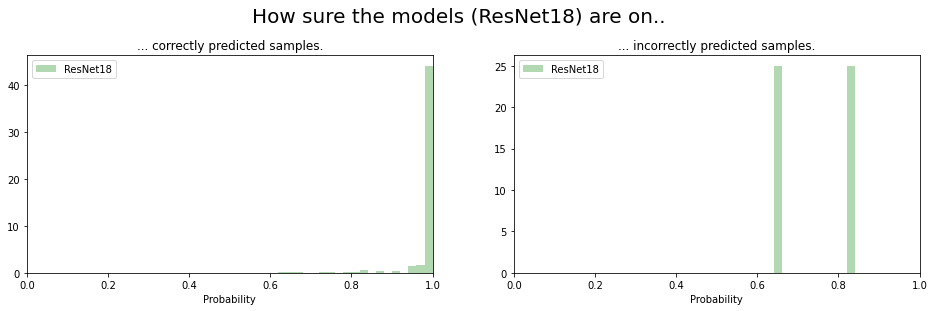

In [ ]:
plot_hist(models=[loaded_model], loader=testloader, model_names=["ResNet18"])

#### Probabilites: A simple CNN

In [7]:
# model structure

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3,16,5,1)
        self.conv2 = nn.Conv2d(16,32,5,1)
        self.conv3 = nn.Conv2d(32,64,3,1)
        self.fc1 = nn.Linear(576, 128) 
        self.fc2 = nn.Linear(128, 3)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,4,4)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,4,4)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,4,4)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Accuracy is still rather high.

In [8]:
PATH = 'models/simple_cnn_2.pth'
ours_cnn = SimpleCNN()
ours_cnn.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
check_predictions(ours_cnn, testloader)

Accuracy is: 99.6


Sometimes, our cnn is less sure when making incorrect predictions than Resnet18, sometimes it is more sure. 

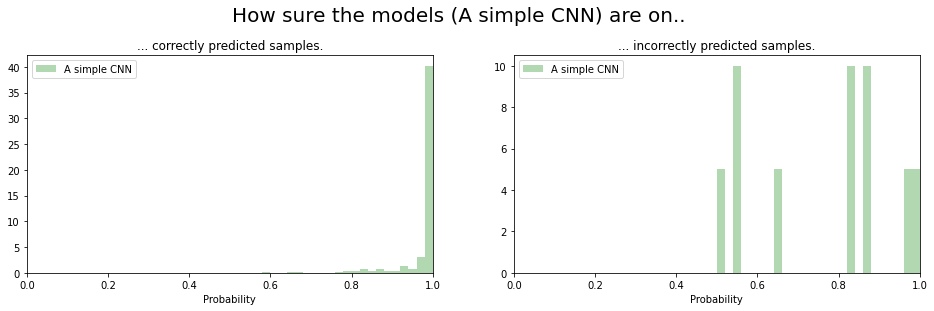

In [ ]:
plot_hist(models=[ours_cnn], loader=testloader, model_names=["A simple CNN"])

#### Probabilites: pretrained ResNet18 vs simple CNN

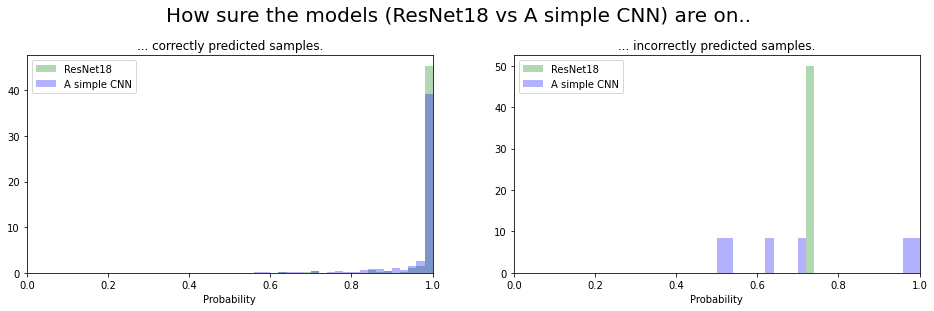

In [ ]:
print("Test set")
plot_hist(models=[loaded_model, ours_cnn], loader=testloader, model_names=["ResNet18", "A simple CNN"])
print("Test set")
plot_hist(models=[loaded_model, ours_cnn], loader=testloader, model_names=["ResNet18", "A simple CNN"])
print("Test set")
plot_hist(models=[loaded_model, ours_cnn], loader=testloader, model_names=["ResNet18", "A simple CNN"])

## Previous explanations

In [ ]:
total=0
correct=0
inputs, labels = next(iter(testloader))
inputs, labels = inputs.to(device), labels.to(device)
outputs = loaded_model(inputs)
_, pred = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (pred == labels).sum().item()
print(100 * correct / total)

100.0


torch.Size([16, 3, 256, 256])
tensor([2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1])
tensor([2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1])
label: true, pred: true (0.9999715089797974)
label: false, pred: false (0.9860296845436096)
label: true, pred: true (0.9999983310699463)
label: counterfactual, pred: counterfactual (0.9981529116630554)
label: false, pred: false (0.9989344477653503)
label: true, pred: true (0.9990870952606201)
label: counterfactual, pred: counterfactual (0.9801185131072998)
label: true, pred: true (0.999373733997345)
label: false, pred: false (0.9994226694107056)
label: false, pred: false (0.9989515542984009)
label: counterfactual, pred: counterfactual (0.9887722134590149)
label: false, pred: false (0.999777615070343)
label: false, pred: false (0.9995386600494385)
label: counterfactual, pred: counterfactual (0.9920195937156677)
label: false, pred: false (0.9961251616477966)
label: false, pred: false (0.9969419836997986)


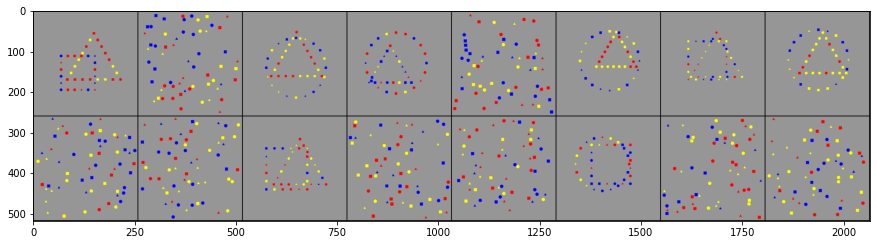

In [ ]:
print(inputs.shape)
print(labels)
print(pred)
grid_testing = torchvision.utils.make_grid(inputs, nrow=8)

plt.figure(figsize=(15,15))
plt.imshow(grid_testing.permute(1,2,0))

probabilities = nn.functional.softmax(outputs, dim=1).max(dim=1).values.detach().numpy()

for i in range(batch_size):
    print(f"label: {classes[labels[i]]}, pred: {classes[pred[i]]} ({probabilities[i]})")

<class 'torch.Tensor'>
true label: counterfactual
pred label: counterfactual
tensor(0)
0.9980185


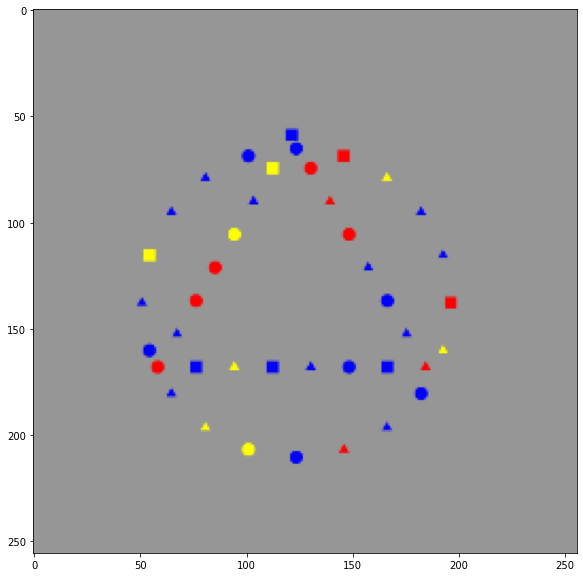

In [ ]:
print(type(inputs[1]))

grid_test = torchvision.utils.make_grid(inputs[0], nrow=10)

plt.figure(figsize=(10,10))
plt.imshow(grid_test.cpu().permute(1,2,0))

print(f'true label: {classes[labels[0]]}')
print(f'pred label: {classes[pred[0]]}')
print(labels[0]) # "2" stands for "true"
print(probabilities[0])

## Representation vector using t-SNE

In [9]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [10]:
@torch.no_grad()
def get_all_preds(model, loader):
  all_preds = torch.tensor([])
  for batch in loader:
    images, labels = batch
    preds = model(images)
    all_preds = torch.cat((all_preds, preds) ,dim=0)

  return all_preds

In [12]:
import copy 
network_for_tsne = copy.deepcopy(ours_cnn)
network_for_tsne.fc2 = nn.Identity()
test_preds = get_all_preds(network_for_tsne, testloader)

In [13]:
filename = 'finalized_model10.pth'
# torch.save(model, filename)
loaded_model_resnet = torch.load(filename)
loaded_model_resnet.fc = nn.Identity()
test_preds_resnet = get_all_preds(loaded_model_resnet, testloader)

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#Simple CNN part
pca = PCA(n_components=50)
pca.fit(test_preds)
pca_features = pca.transform(test_preds)

tsne = TSNE().fit_transform(pca_features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

#Resnet18 part
pca_resnet = PCA(n_components=50)
pca_resnet.fit(test_preds_resnet)
pca_features_resnet = pca_resnet.transform(test_preds_resnet)

tsne_resnet = TSNE().fit_transform(pca_features_resnet)
tx_resnet, ty_resnet = tsne_resnet[:,0], tsne_resnet[:,1]
tx_resnet = (tx_resnet-np.min(tx_resnet)) / (np.max(tx_resnet) - np.min(tx_resnet))
ty_resnet = (ty_resnet-np.min(ty_resnet)) / (np.max(ty_resnet) - np.min(ty_resnet))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


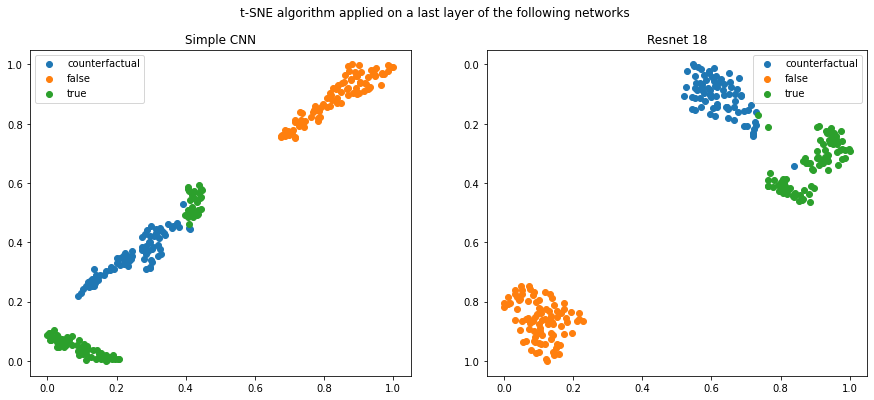

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('t-SNE algorithm applied on a last layer of the following networks')

y_test = np.array([i[1] for i in test_dataset]) # real labels
for i in range(len(classes)):
    y_i = y_test == i
    ax1.scatter(tx[y_i[:]], ty[y_i[:]], label=classes[i])
ax1.legend()
ax1.set_title('Simple CNN')

for i in range(len(classes)):
    y_i = y_test == i
    ax2.scatter(tx_resnet[y_i[:]], ty_resnet[y_i[:]], label=classes[i])
ax2.legend()
ax2.set_title('Resnet 18')

plt.gca().invert_yaxis()
plt.show()

## Explanations
Various explanations are presented below, such as Lime, Shap and Integrated Gradients. For each class two pictures were examined. 


In [ ]:
%%capture
!pip install captum
!pip install scikit-image

In [ ]:
from captum.attr import Lime
from skimage import segmentation
from captum.attr import visualization
from captum.attr import IntegratedGradients
from captum.attr import KernelShap

#### Helper functions - explanations

In [ ]:
def compute_mask(image):
    mask = segmentation.quickshift(
        image.permute(1, 2, 0).double(), 
        kernel_size=50, 
        max_dist=7, 
        ratio=0.7
    )
    return mask

def show_attr_ig(attr_map, label):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True,
        title= f"Integrated Gradients - {classes[label]}"
    )

def show_attr_shap(attr_map, label):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True,
        title= f"Shap - {classes[label]}"
    )

def exp_shap(image, label, network, mask):
    exp = KernelShap(network)
    exp = exp.attribute(
        image.unsqueeze(0), 
        target=label, 
        n_samples=300, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
    )
    return exp

def exp_Lime(image, label, newtork, mask):
    explainer = Lime(newtork)
    attr = explainer.attribute(
        image.unsqueeze(0),
        target=label, 
        n_samples=20, 
        feature_mask=torch.as_tensor(mask),
        show_progress=True
    )
    return attr

def exp_ig(image, label, newtork):
    exp_ig = IntegratedGradients(newtork)
    attr_ig = exp_ig.attribute(image.unsqueeze(0), target=label)
    return attr_ig  

def show_image_mask_explanation(image, mask, explanation, label):
    fig, ax = plt.subplots(1, 3, figsize=[6 * 2, 6])
    fig.suptitle(f'Lime Explanations - {classes[label]}', fontsize=20,y=0.85)
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask, cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(explanation, vmin=-1, vmax=1, cmap="RdBu")
    ax[2].set_title("explanation")
    plt.show()

def compute_mask_for_item(number):
    inputs, labels = next(iter(testloader))
    image = inputs[number]
    label = labels[number].item()
    mask = compute_mask(image)
    return image, label, mask

def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

def show_attr(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

def show_attr_abs(attr_map):
    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='absolute_value',
        show_colorbar=True
    )

def normalize_anything(attr_map, str_sign):
    return visualization._normalize_image_attr(attr_map.permute(1, 2, 0).numpy(), sign=str_sign, outlier_perc=2)

#### Example 1 - True

In [ ]:
image, label, mask = compute_mask_for_item(0)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 125.39it/s]


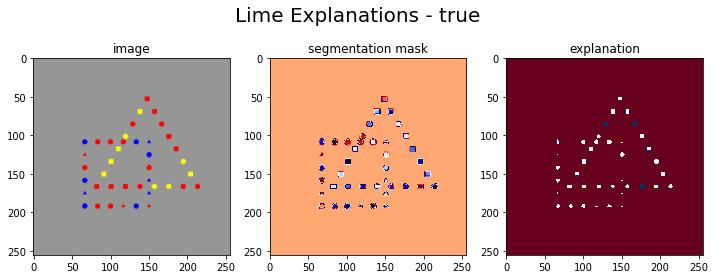

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 83.56it/s]


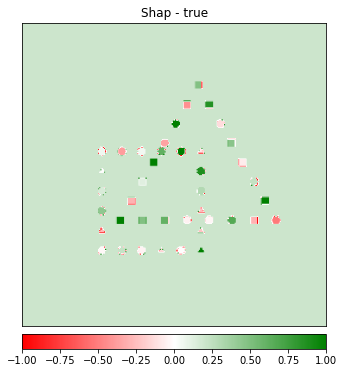

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

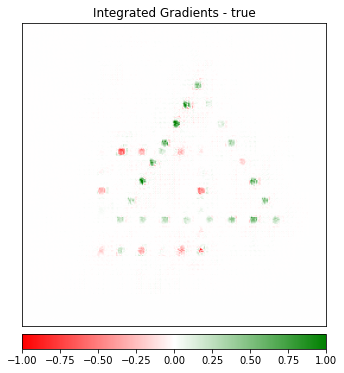

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 2 - True

In [ ]:
image, label, mask = compute_mask_for_item(2)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 119.54it/s]


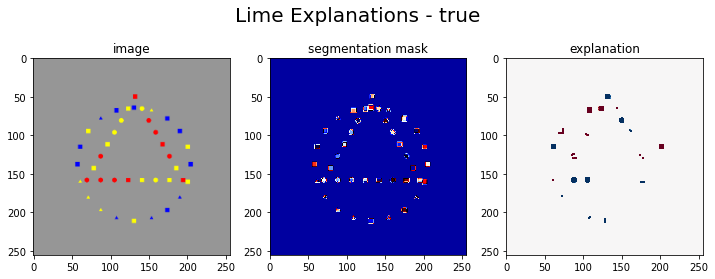

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:05<00:00, 55.34it/s]


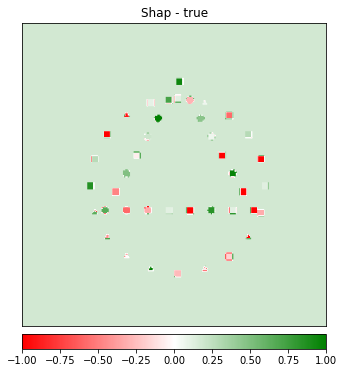

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

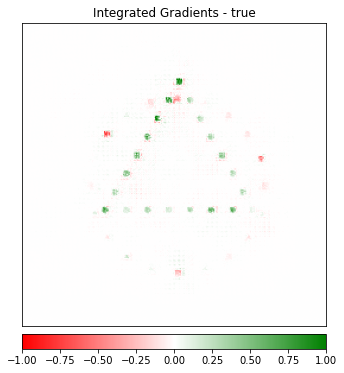

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 3 - Counterfactual

In [ ]:
image, label, mask = compute_mask_for_item(3)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 120.40it/s]
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.079e-02, tolerance: 6.867e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


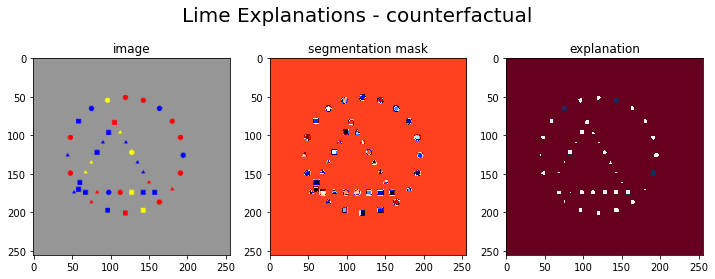

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 87.70it/s]


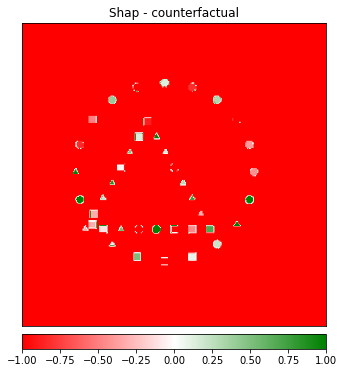

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

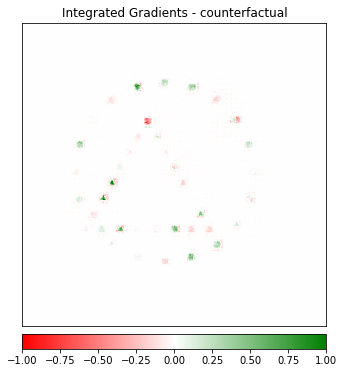

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 4 - Counterfactual

In [ ]:
image, label, mask = compute_mask_for_item(6)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 116.84it/s]


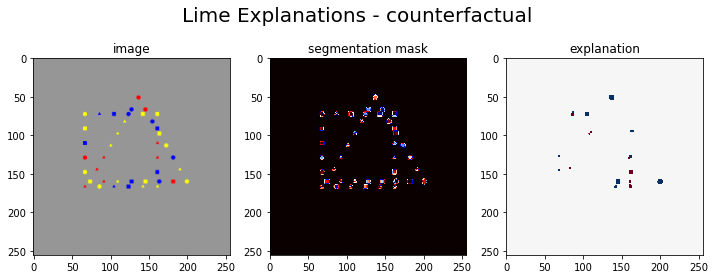

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 89.68it/s]


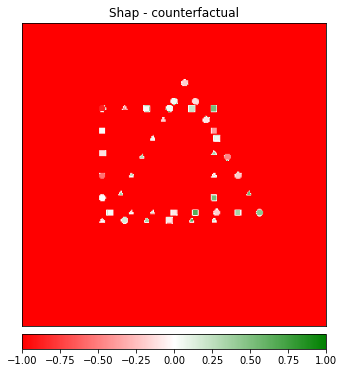

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

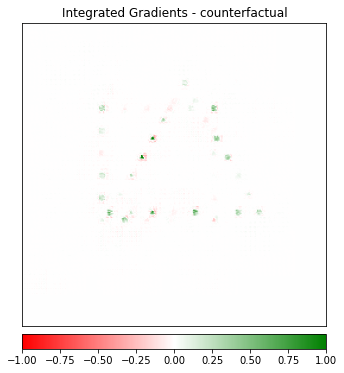

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 5 - false

In [ ]:
image, label, mask = compute_mask_for_item(1)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 118.78it/s]


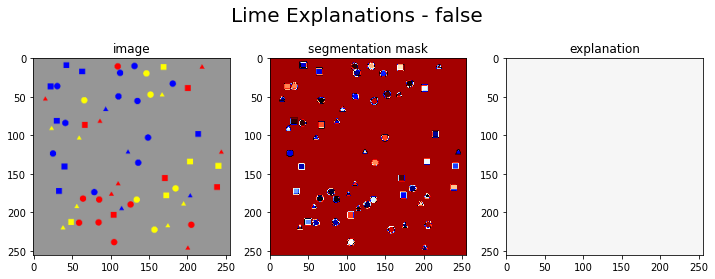

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 85.67it/s]


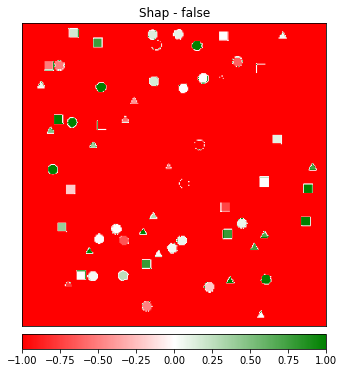

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

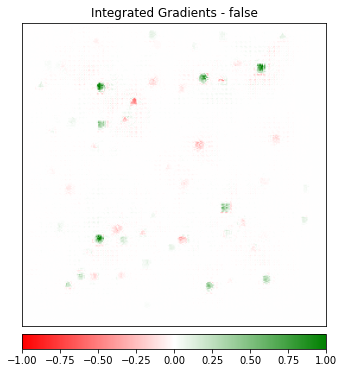

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

#### Example 6 - false

In [ ]:
image, label, mask = compute_mask_for_item(4)

Lime attribution: 100%|██████████| 20/20 [00:00<00:00, 129.08it/s]


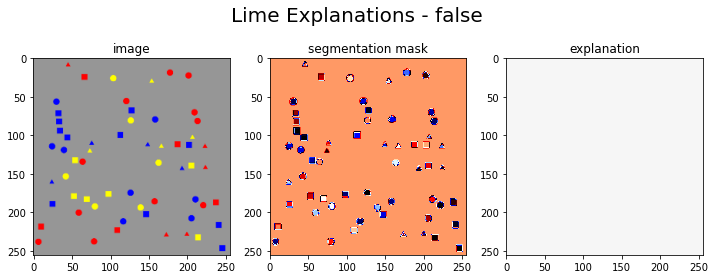

In [ ]:
attr_lime = exp_Lime(image, label, ours_cnn, mask)
show_image_mask_explanation(image, mask, attr_lime[0].mean(axis=0)*100000, label)

Kernel Shap attribution: 100%|██████████| 300/300 [00:03<00:00, 83.88it/s]


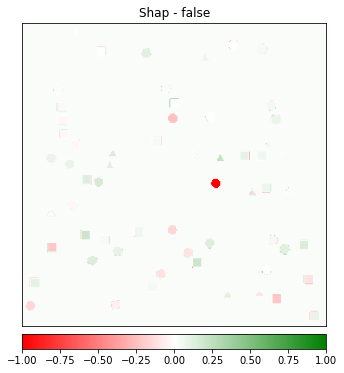

In [ ]:
attr_shap = exp_shap(image, label, ours_cnn, mask)
show_attr_shap(attr_shap[0], label)

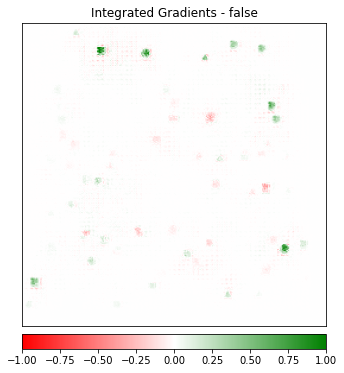

In [ ]:
attr_ig = exp_ig(image, label, ours_cnn)
show_attr_ig(attr_ig[0], label)

### Explanations on new CNN model

#### Local

In the SHAP explanation of an image from the class *false*, some figures further from the center are marked as contributing to this image being classified as from class *false*. It may be caused by most of the small figures in other classes being closer to the center. However, some small figures close to the sides and corners are not green. IG didn't explain much.

#### Global

There are currently two ideas about global explanations, which we are investigating. First one focuses on finding pixels, which are most important for the explanations of a model and finding their original color. Currently, experiments were done on one image and colors are printed on console, but in next steps, results will be achieved on more images and the colors will be printed as a summary.\
Second attempt is to sum most important (abs) parts of images and normalize them, to see, which parts of images were having usually the biggest impact on the result of a model. Until now, we can see that the resulting images seems to hardly be readible, and we only implemented it on a few images. Further investigation, for more readible way of showing results will be conducted.

##### Helper functions - global explanations

In [ ]:
import numpy as np
from matplotlib import colors
from scipy.spatial import cKDTree as KDTree

def get_pixel_colors_for_image(image_matrix):
    # source: https://stackoverflow.com/questions/50545192/count-different-colour-pixels-python
    use_colors = {k: colors.cnames[k] for k in ['red', 'yellow', 'blue', 'gray', 'purple']}
    named_colors = {k: tuple(map(int, (v[1:3], v[3:5], v[5:7]), 3*(16,))) for k, v in use_colors.items()}
    ncol = len(named_colors)

    color_tuples = list(named_colors.values())
    color_tuples.append(named_colors.pop('purple'))
    color_tuples = np.array(color_tuples)

    color_names = list(named_colors)
    color_names.append('no match')

    img = image_matrix.permute(1,2,0)*255

    tree = KDTree(color_tuples[:-1])
    dist, idx = tree.query(img, distance_upper_bound=np.inf)

    codes = {0: 'red', 1: 'yellow', 2: 'blue', 3:"gray"}
    pixel_colors = np.asarray(list(codes.values()))[idx]
    return pixel_colors   

In [ ]:
pixel_colors = get_pixel_colors_for_image(inputs[0])
print(f"Shape: {pixel_colors.shape}")
pixel_colors

Shape: (256, 256)


array([['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ...,
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray'],
       ['gray', 'gray', 'gray', ..., 'gray', 'gray', 'gray']], dtype='<U6')

In [ ]:
#version for deepnote
PATH = 'models/simple_cnn_2.pth'
network = SimpleCNN()
network.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
inputs=torch.load('explanation_mess/inputs')
pred=torch.load('explanation_mess/pred')
labels=torch.load('explanation_mess/labels')
exp_shape=torch.load('explanation_mess/to_show_second')

##### First attempt

Kernel Shap attribution: 100%|██████████| 30/30 [00:00<00:00, 131.65it/s]


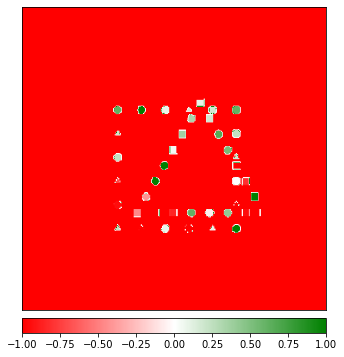

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

exp_ks_10_2 = KernelShap(network)

mask_101 = segmentation.quickshift(
    inputs[2].permute(1, 2, 0).double(), 
    kernel_size=50, 
    max_dist=7, 
    ratio=0.7
  )

exp_ks_10_2 = exp_ks_10_2.attribute(
    inputs[2].unsqueeze(0), 
    target=2, 
    n_samples=30, 
    feature_mask=torch.as_tensor(mask_101),
    show_progress=True
  )

show_attr(exp_ks_10_2[0])

In [ ]:
import copy
normalized_output_trial=normalize_anything(exp_ks_10_2[0], 'all')
normalized_big=copy.deepcopy(normalized_output_trial)
normalized_small=copy.deepcopy(normalized_output_trial)
normalized_big[normalized_big<0.8]=0
normalized_small[normalized_small>(-0.8)]=0
normalized_output_trial=normalized_big+normalized_small
normalized_output_trial

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

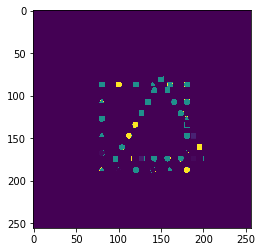

In [ ]:
plt.imshow(normalized_output_trial, interpolation='nearest')
plt.show()

#yellow are above 0.8, purple below, blue 0

In [ ]:
#let's find all yellow
normalized_choosing=copy.deepcopy(normalized_big)
last=5
new_label=2
#saving indexes
for i in range (len(normalized_choosing)):
    for j in range (len(normalized_choosing[0])):
        if normalized_choosing[i][j]!=0:
            # if last !=normalized_choosing[i][j] and i>=1 and normalized_choosing[i-1][j]:
            #     #we enter new sector
            print('coordinates')
            print(f'{i},{j}')
            print('colors')
            print(f'{pixel_colors[i][j]}')
            #print(f'{inputs[0][0][i][j]}, {inputs[0][1][i][j]}, {inputs[0][2][i][j]}')


coordinates
84,79
colors
gray
coordinates
84,100
colors
gray
coordinates
84,101
colors
gray
coordinates
84,119
colors
gray
coordinates
84,147
colors
gray
coordinates
84,148
colors
gray
coordinates
84,149
colors
gray
coordinates
84,150
colors
gray
coordinates
84,151
colors
gray
coordinates
84,152
colors
gray
coordinates
84,159
colors
gray
coordinates
84,160
colors
gray
coordinates
84,161
colors
gray
coordinates
84,178
colors
gray
coordinates
85,98
colors
gray
coordinates
85,99
colors
gray
coordinates
85,100
colors
gray
coordinates
85,101
colors
gray
coordinates
85,102
colors
gray
coordinates
85,177
colors
gray
coordinates
86,77
colors
gray
coordinates
86,98
colors
gray
coordinates
86,99
colors
gray
coordinates
86,100
colors
gray
coordinates
86,101
colors
gray
coordinates
86,102
colors
gray
coordinates
86,103
colors
gray
coordinates
86,117
colors
gray
coordinates
86,157
colors
gray
coordinates
86,163
colors
gray
coordinates
87,97
colors
gray
coordinates
87,98
colors
gray
coordinates
87,9

Text(0.5, 1.0, 'choosen most\n important - smallest')

<Figure size 432x288 with 0 Axes>

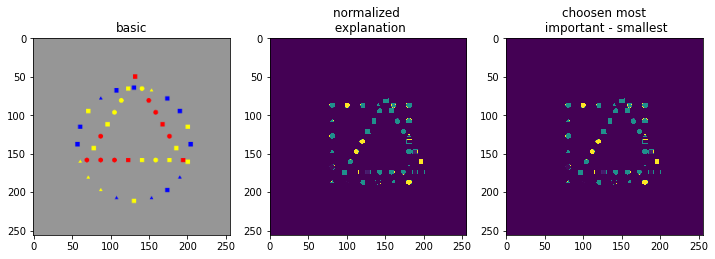

In [ ]:
#to update last images after creating it; placeholder

grid_testing = torchvision.utils.make_grid(inputs[2], nrow=8)
plt.figure()#figsize=(30,30))
f, axarr = plt.subplots(1,3, figsize=[6*2,6]) 
#plt.imshow(grid_testing.permute(1,2,0))
axarr[0].imshow(grid_testing.permute(1,2,0))
axarr[0].set_title("basic")
axarr[1].imshow(normalized_output_trial, interpolation='nearest')
axarr[1].set_title("normalized \n explanation")
axarr[2].imshow(normalized_output_trial, interpolation='nearest')
axarr[2].set_title("choosen most\n important - smallest")

##### Second attempt

100.0
torch.Size([16, 3, 256, 256])
tensor([2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1])
tensor([2, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 1])
label: true, pred: true (0.9991424083709717)
label: false, pred: false (0.9999892711639404)
label: true, pred: true (0.9999932050704956)
label: counterfactual, pred: counterfactual (0.9285325407981873)
label: false, pred: false (0.9999984502792358)
label: true, pred: true (0.9999657869338989)
label: counterfactual, pred: counterfactual (0.9940709471702576)
label: true, pred: true (0.9998724460601807)
label: false, pred: false (0.9999877214431763)
label: false, pred: false (0.9982901215553284)
label: counterfactual, pred: counterfactual (0.9928507804870605)
label: false, pred: false (0.9978567957878113)
label: false, pred: false (0.9999985694885254)
label: counterfactual, pred: counterfactual (0.833036482334137)
label: false, pred: false (0.9999992847442627)
label: false, pred: false (0.9993155002593994)
found in batch 0, picture 0
Kernel 

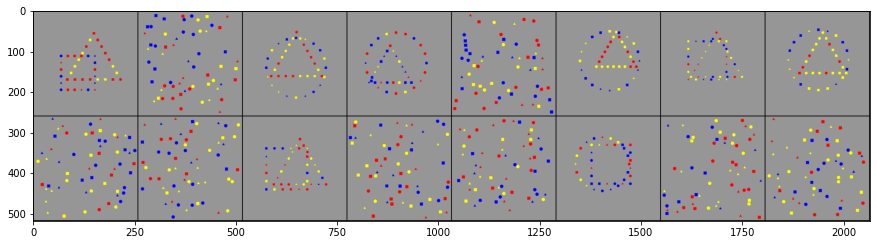

In [ ]:
#version for deepnote
PATH = 'models/simple_cnn_2.pth'
network = SimpleCNN()
network.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

total=0
correct=0
some_output_new1= np.zeros((256,256))
for i, data in enumerate(testloader, 0):
        if i >= 1:
            break
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        #normal printing accuracy 
        outputs = network(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
        print(100 * correct / total)
        total=0
        correct=0

        #sum of shap outputs

        print(inputs.shape)
        print(labels)
        print(pred)
        grid_testing = torchvision.utils.make_grid(inputs, nrow=8)

        plt.figure(figsize=(15,15))
        plt.imshow(grid_testing.permute(1,2,0))

        probabilities = nn.functional.softmax(outputs, dim=1).max(dim=1).values.detach().numpy()

        for k in range(batch_size):
            print(f"label: {classes[labels[k]]}, pred: {classes[pred[k]]} ({probabilities[k]})")
        count_num=0
        for j in range(batch_size):
            if labels[j]==pred[j] and labels[j]==2:
                print(f'found in batch {i}, picture {j}')
                # if count_num>=1:
                #     break
                exp_ks_2_new = KernelShap(network)

                mask_2new = segmentation.quickshift(
                    inputs[j].permute(1, 2, 0).double(), 
                    kernel_size=50, 
                    max_dist=7, 
                    ratio=0.7
                )

                exp_ks_2_new = exp_ks_2_new.attribute(
                    inputs[j].unsqueeze(0), 
                    target=2, 
                    n_samples=30, 
                    feature_mask=torch.as_tensor(mask_2new),
                    show_progress=True
                )

                #sum_exp+=exp_ks_2_new[0]
                new_normalized=normalize_anything(exp_ks_2_new[0], "absolute_value")
                new_normalized[new_normalized!=1.0]=0
                some_output_new1+=new_normalized
                count_num+=1

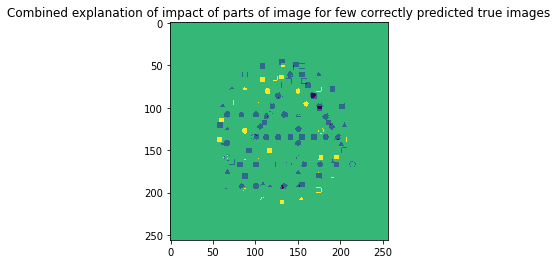

In [ ]:
plt.imshow(some_output_new1, interpolation='nearest')
plt.title('Combined explanation of impact of parts of image for few correctly predicted true images')
plt.show()

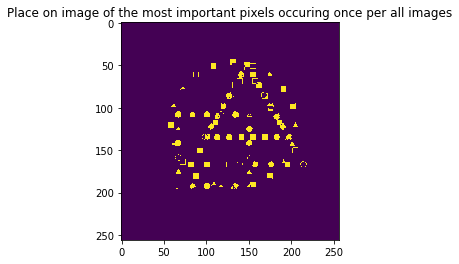

In [ ]:
only_four=some_output_new1.copy()
only_four[only_four!=1.0]=0

plt.imshow(only_four, interpolation='nearest')
plt.title('Place on image of the most important pixels occuring once per all images')
plt.show()

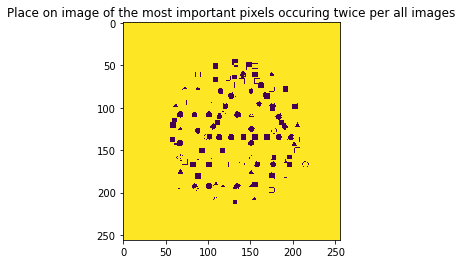

In [ ]:
only_four=some_output_new1.copy()
only_four[only_four!=2.0]=0

plt.imshow(only_four, interpolation='nearest')
plt.title('Place on image of the most important pixels occuring twice per all images')
plt.show()

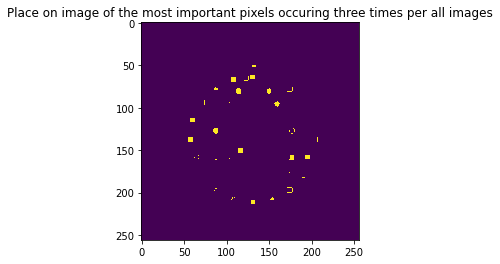

In [ ]:
only_four=some_output_new1.copy()
only_four[only_four!=3.0]=0

plt.imshow(only_four, interpolation='nearest')
plt.title('Place on image of the most important pixels occuring three times per all images')
plt.show()

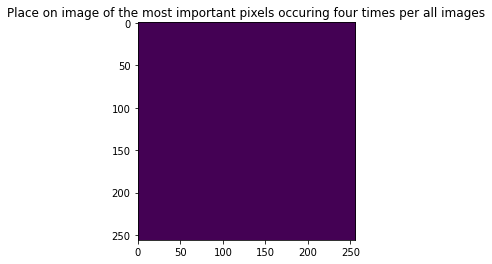

In [ ]:
only_four=some_output_new1.copy()
only_four[only_four!=4.0]=0

plt.imshow(only_four, interpolation='nearest')
plt.title('Place on image of the most important pixels occuring four times per all images')
plt.show()

### Summary of attempts

TO DO [...]

Further investigation about global methods and their implementation will be conducted in next steps of this project.



## Articles 

### Article 1

Title: **Multifaceted Feature Visualization: Uncovering the Different Types of Features Learned By Each Neuron in Deep Neural Networks**  
Authors: Anh Nguyen, Jason Yosinski, Jeff Clune  
Publisher: 'Visualization for Deep Learning' workshop at ICML 2016 conference  
Link: [author's page](https://anhnguyen.me/project/mfv/), [https://arxiv.org/pdf/1602.03616.pdf](https://arxiv.org/pdf/1602.03616.pdf) 

In a neural network each neuron usually responds in a different way to input data and it is therefore possible to find special patterns (*facets*) that a given neuron responds to the most by generating such special. The article presents a method better than the previous methods at creating these special images in a few criterias - fewer repeating patterns (such as many ostrich heads without a body), color makes more sense, sides of the image are less important. The most important part is that this new method called *Multifaceted Feature Visualization* is that it creates one image per special pattern (*facet*) the neuron recognizes instead of mixing them all in a single image. Number of patters is chosen maunally.

### Article 2

Title: **Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps**  
Authors: K. Simonyan, A. Vedaldi, A. Zisserman \
Publisher: arXiv \
Link: [https://arxiv.org/abs/1312.6034](https://arxiv.org/abs/1312.6034)

In this article authors proposed two ways of visualising the explanations of a model (ConvNet) and compared them with already existing method. An advantage of this article is that the authors provided implementation details of later explained neural net. Firstly, they introduced class model visualisation, providing some mathematical details and few images as examples. Second method focused on ranking pixels of an image based on their impact on the score of a classification. The main disadvantage of this article is lack of the sample implementations of those methods, which would help in understanding the work of this algorithm.



### Article 3

Title: **A unified approach to interpreting model predictions**  
Authors: Scott M. Lundberg, Su-In Lee\
Publisher: NIPS'17: Proceedings of the 31st International Conference on Neural Information Processing Systems   \
Link: [https://dl.acm.org/doi/10.5555/3295222.3295230](https://dl.acm.org/doi/10.5555/3295222.3295230)

The article introduces the concept of Shapley Additive explanation values called SHAP values which attributes an importance value to each feature for a given prediction and has its roots in game theory. It defines the class of additive feature attribution methods, formulates important theorems and identifies that six previously developed explanation methods are members of this class and share desirable mathematical properties. It presents several methods for estimations of SHAP values for different models and assumptions. It shows that this method outperforms other methods and yields better results. The article gives a theoretical foundation for this promising method and encourages others to work on it. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc6ece19-7b0a-4a42-9a06-463a643dea3a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>